In [1]:
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt

In [3]:
f_VISIR=("VISIR.2018-07-02T03_49_31.147.fits")
hdu=fits.open(f_VISIR)

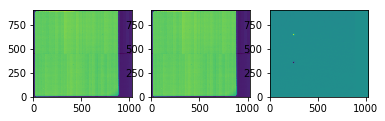

In [7]:
plt.subplot(131)
plt.imshow(hdu[1].data,origin="lower")
plt.subplot(132)
plt.imshow(hdu[2].data,origin="lower")
plt.subplot(133)
plt.imshow(hdu[3].data,origin="lower")

The first two extensions hold the summed frames of chop positions A and B respectively; the third extension holds the (summed) chop-difference frame

## Expected noise if the noise was photon-shot noise limited

The standard deviation of a Poissonian-distributed signal is sqrt(avg), where avg is the average signal. For this application, we need to take into account, that the Poissonian distribution applies to the arrival time distribution of photons (or equivalently photo-electrons), but not for the converted digital signal. We therefore need to convert the digital signal into an electron signal by (1) removing the bias and (2) multiplying with the gain. We used the measured gain of the Aquarius detector in high-gain mode: 15 e/ADU (Ives+ 2012, SPIE proc. Fig. 11a)

In [13]:
gain = 15

ADU_avg = np.average(hdu[1].data[100:200,100:200])
ADU_bias = np.average(hdu[1].data[0:100,900:1000])
ADU_bias_subtracted = ADU_avg - ADU_bias
e_avg = ADU_bias_subtracted * gain
print(ADU_avg,ADU_bias,ADU_bias_subtracted,e_avg)

The expected noise in this frame is therefore:

In [20]:
noise_e_avg = np.sqrt(e_avg)
noise_e_avg

786.1191390503413

In order to compare this to the noise in the final image, we need to know how many frames have been averaged for the final pair of frames (chop A, chop B). We get this information from the header:

In [25]:
ndit_per_choppos = hdu[0].header["HIERARCH ESO DET NDIT"]
n_chopcycles = hdu[0].header["HIERARCH ESO DET CHOP NCYCLES"]
print("The number of frames in each chop A/B position is: ", ndit_per_choppos*n_chopcycles)

The number of frames in each chop A/B position is:  2637


To double check if this is OK, we can compare the summed up detector integration times (DITs) of the indivual frames with the total exposure time:

In [27]:
dit = hdu[0].header["HIERARCH ESO DET SEQ1 DIT"]
exptime = hdu[0].header["HIERARCH ESO DET SEQ1 EXPTIME"]
print("The sum of all DITs is", dit*ndit_per_choppos*n_chopcycles*2) ## There are two positions (chop A/B) per chop cycle
print("The total exposure time is", exptime)

The sum of all DITs is 60.123599999999996
The total exposure time is 73.4844


The difference in these two numbers is due to dead time in between the chopping positions / set up time and other overheads.

The expected noise in the chop-difference frame is therefore:

In [31]:
expected_noise = noise_e_avg * np.sqrt(2) / np.sqrt(ndit_per_choppos*n_chopcycles) ## sqrt(2) from the subtraction of chop A - chop B in the combined image
print(expected_noise)

21.649521540231156


## Actual noise

In [11]:
# Noise in final combined frame outside the position of the star
s_avg_ADU = np.std(hdu[3].data[100:200,100:200])
s_avg_ADU

1.5270067

Convert this into an equivalent photo-electron noise.

In [32]:
s_avg_e = s_avg_ADU*gain
s_avg_e

22.9051011800766

The actual noise is very close to the expected noise for a Poisson distribution. It is therefore reasonable to conclude that the photon shot-noise is the dominant noise source and the exposure has therefore as little noise as possible. Detector noise sources do not contribute significantly.